# 目的
- チョコボールの数の変遷を調べる

In [1]:
import sys, os
import sqlite3
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt

from datetime import datetime as dt

import ChocoUtils as util

# jupyterの日本語設定
import matplotlib
from matplotlib.font_manager import FontProperties

font_path = '/usr/share/fonts/truetype/takao-gothic/TakaoPGothic.ttf'
font_prop = FontProperties(fname=font_path)
matplotlib.rcParams['font.family'] = font_prop.get_name()

In [2]:
# seaborneスタイルセット
import seaborn as sns
sns.set()
sns.set_style('darkgrid') # プリセットのスタイル
sns.set_context("paper")  # スケール

In [3]:
db_file = '../data/choco-ball.db'
f_str = 'taste = 0 and best_before is not null'
p_data = util.get_data(db_file=db_file, filter_str=f_str)
data = p_data.drop(columns='shop')

SELECT measure_date, best_before, prd_number, weight, box_weight, ball_number, factory, shop, angel, campaign, taste, buyer, (weight - box_weight), (weight - box_weight)/ball_number FROM measurement WHERE taste = 0 and best_before is not null;
Shape of MeasurementData(record_num, n_columns) : (129, 14)


In [4]:
data_base = data.copy()
data.sort_values(by='best_before', inplace=True)
#data = data_base.sort_values(by='measure_date')

# データを眺める
- 正味の重量には変化が見られない
- 中央のチョコボールの数は50箱目くらいで数が減ったようにも見える
- 右図の1個あたり平均重量を見ると40箱目くらいで変わったように見える
    - 全体重量は変わらないので、1個あたり平均重量が増えるということは、粒が大きくなったということを示す

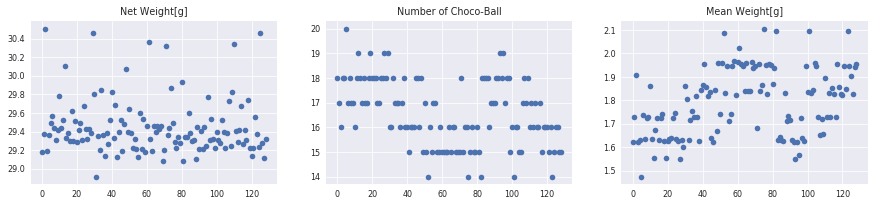

In [20]:
fig = plt.figure(figsize=(15, 3))
ax = fig.subplots(1, 3)

ax[0].plot(data['net_weight'], 'o')
ax[0].set_title('Net Weight[g]')
ax[1].plot(data['ball_number'], 'o')
ax[1].set_title('Number of Choco-Ball')
ax[2].plot(data['mean_weight'], 'o')
ax[2].set_title('Mean Weight[g]')

fig.savefig('./fig/data_plot.png')

# チョコボール数の変化点検出

## モデル
- pymc本p.16参照
- ある計測のチョコボールの数はポアソン分布に従うとする
    - $N_i \sim Poi(\lambda)$
- 変化点$\tau$でポアソン分布のパラメータ$\lambda$が変化したとする（$\lambda_1 to \lambda_2$）
- $\lambda$は指数分布を事前分布とする
    - $\lambda_i \sim Exp(\alpha)$
- 変化点$\tau$は事前分布として一様分布を使う

In [6]:
import pymc as pm

In [7]:
# 事前分布のパラメータ$\alpha$
alpha = 1.0 / data['ball_number'].mean()

# ポアソン分布のパラメータ$\lmabda$の初期分布
lambda_1 = pm.Exponential("lambda_1", alpha)
lambda_2 = pm.Exponential("lambda_2", alpha)

# 変化点$\tau$の初期化
n_data = data.shape[0]
tau = pm.DiscreteUniform("tau", lower=0, upper=n_data)

In [8]:
@pm.deterministic
def lambda_(tau=tau, lambda_1=lambda_1, lambda_2=lambda_2):
    out = np.zeros(n_data)
    out[:tau] = lambda_1
    out[tau:] = lambda_2
    return out

In [9]:
# 観測データを結びつける
observation = pm.Poisson("obs", lambda_, value=np.array(data['ball_number']), observed=True)
model = pm.Model([observation, lambda_1, lambda_2, tau])

mcmc = pm.MCMC(model)
mcmc.sample(150000, 50000)

 [-----------------100%-----------------] 150000 of 150000 complete in 24.4 sec

In [10]:
lambda_1_sample = mcmc.trace('lambda_1')[:]
lambda_2_sample = mcmc.trace('lambda_2')[:]
tau_sample = mcmc.trace('tau')[:]

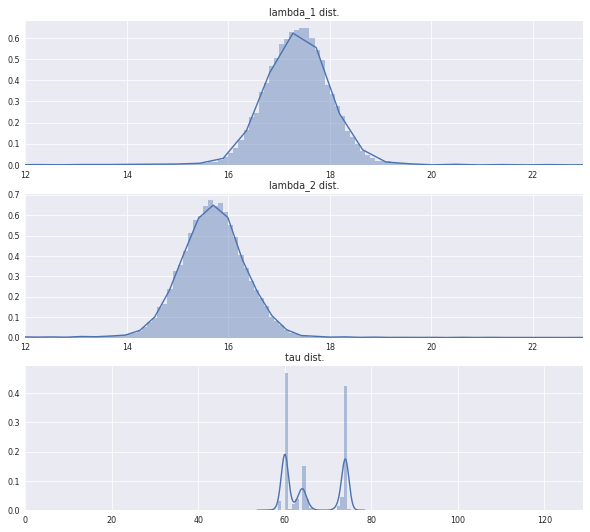

In [18]:
fig = plt.figure(figsize=(10, 9))
ax = fig.subplots(3, 1)

bs = np.arange(12, 23, 0.1)
sns.distplot(lambda_1_sample, ax=ax[0], bins=bs, label='lambda_1')
ax[0].set_xlim([12, 23])
ax[0].set_title('lambda_1 dist.')
sns.distplot(lambda_2_sample, ax=ax[1], bins=bs, label='lambda_2')
ax[1].set_xlim([12, 23])
ax[1].set_title('lambda_2 dist.')
sns.distplot(tau_sample, ax=ax[2], label='tau')
ax[2].set_xlim([0, n_data])
ax[2].set_title('tau dist.')
fig.savefig('./fig/number_diff.png')

### 統計的に変化していると言えるのか
- 2つの分布のパラメータ$\lambda_1$と$\lambda_2$に差があるのかを評価
- 差があることは確信している

In [12]:
print((lambda_1_sample > lambda_2_sample).mean())

0.95295


## 平均重量の差異

In [13]:
# 事前分布のパラメータ$\alpha$
o_mu = data['mean_weight'].mean()
o_var = data['mean_weight'].var()

# ポアソン分布のパラメータ$\lmabda$の初期分布
mu_1 = pm.Normal("mu_1", o_mu, 0.01)
mu_2 = pm.Normal("mu_2", o_mu, 0.01)

# 分散の初期分布(一様分布)
sig_1 = 1.0 / pm.Uniform("std_1", 0, 100)**2
sig_2 = 1.0 / pm.Uniform("std_2", 0, 100)**2

# 変化点$\tau$の初期化
n_data = data.shape[0]
tau = pm.DiscreteUniform("tau", lower=0, upper=n_data)

In [14]:
@pm.deterministic
def center_(tau=tau, mu_1=mu_1, mu_2=mu_2):
    out = np.zeros(n_data)
    out[:tau] = mu_1
    out[tau:] = mu_2
    return out

@pm.deterministic
def sig_(tau=tau, sig_1=sig_1, sig_2=sig_2):
    out = np.zeros(n_data)
    out[:tau] = sig_1
    out[tau:] = sig_2
    return out

In [15]:
# 観測データを結びつける
observation = pm.Normal("obs", center_, sig_, value=np.array(data['mean_weight']), observed=True)
model = pm.Model([observation, mu_1, mu_2, sig_1, sig_2, tau])

mcmc = pm.MCMC(model)
mcmc.sample(50000, 10000)

 [-----------------100%-----------------] 50000 of 50000 complete in 14.5 sec

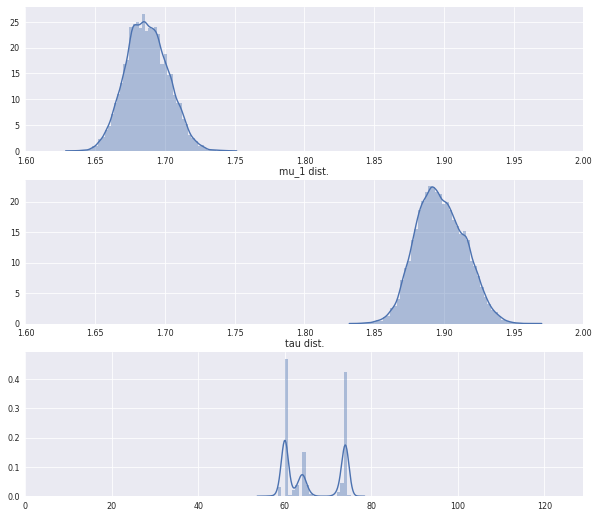

In [19]:
mu_1_sample = mcmc.trace('mu_1')[:]
mu_2_sample = mcmc.trace('mu_2')[:]
tau_sample = mcmc.trace('tau')[:]

fig = plt.figure(figsize=(10, 9))
ax = fig.subplots(3, 1)

sns.distplot(mu_1_sample, ax=ax[0], label='mu_1')
ax[0].set_xlim([1.6, 2.0])
ax[1].set_title('mu_1 dist.')
sns.distplot(mu_2_sample, ax=ax[1], label='mu_2')
ax[1].set_xlim([1.6, 2.0])
ax[2].set_title('mu_2 dist.')
sns.distplot(tau_sample, ax=ax[2], label='tau')
ax[2].set_xlim([0, n_data])
ax[2].set_title('tau dist.')
fig.savefig('./fig/meanweight_diff.png')

### 統計的に変化していると言えるのか
- 2つの分布のパラメータ$\mu_1$と$\mu_2$に差があるのかを評価
- 差があることは確信している

In [17]:
print((mu_1_sample < mu_2_sample).mean())

1.0
